In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
from datetime import date
from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima


%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")
aapl?



### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

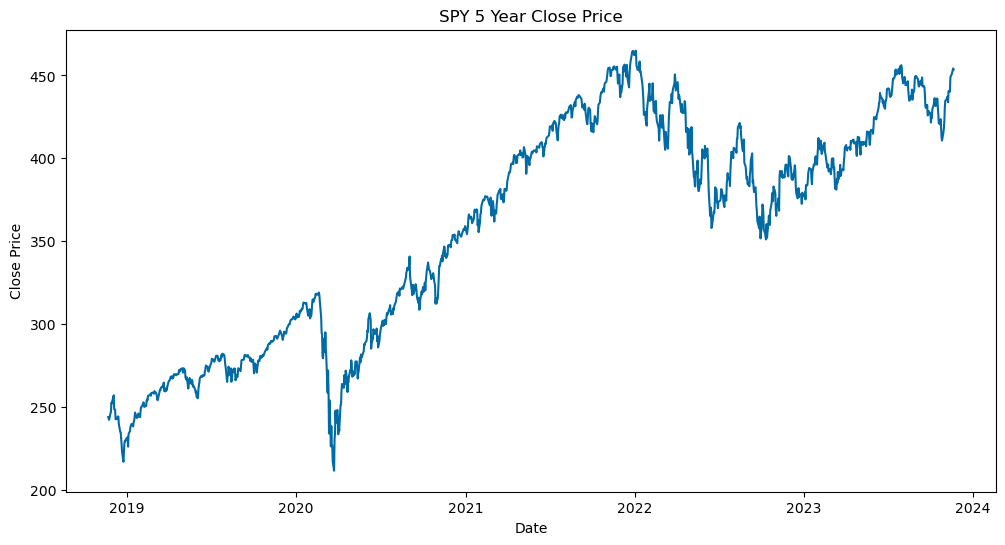

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=300.890767, mean2=415.174707, mean_percent_diff=37.981870
variance1=2047.853323, variance2=679.464030, var_percent_diff=-66.820669


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.316305
p-value: 0.621680
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.703930517278068, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.70
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rkartawi\AppData\Local\Temp\ipykernel_29016\2395884048.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X)


##### P-value < .05; therefore, not stationary

### Transform into stationary series

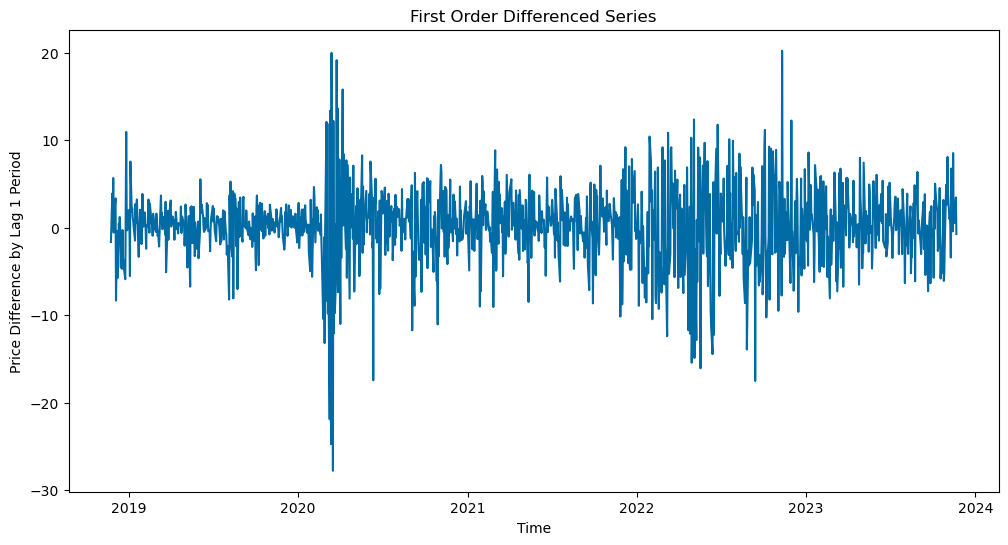

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.785980
p-value: 0.000000
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

Time Series Evaluation Metrics
MSE = 1262.953961611519
MAE = 29.11995043655745
RMSE = 35.538063560238044
MAPE = 0.06746001799269216
r2 = -1.4438583063145076



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


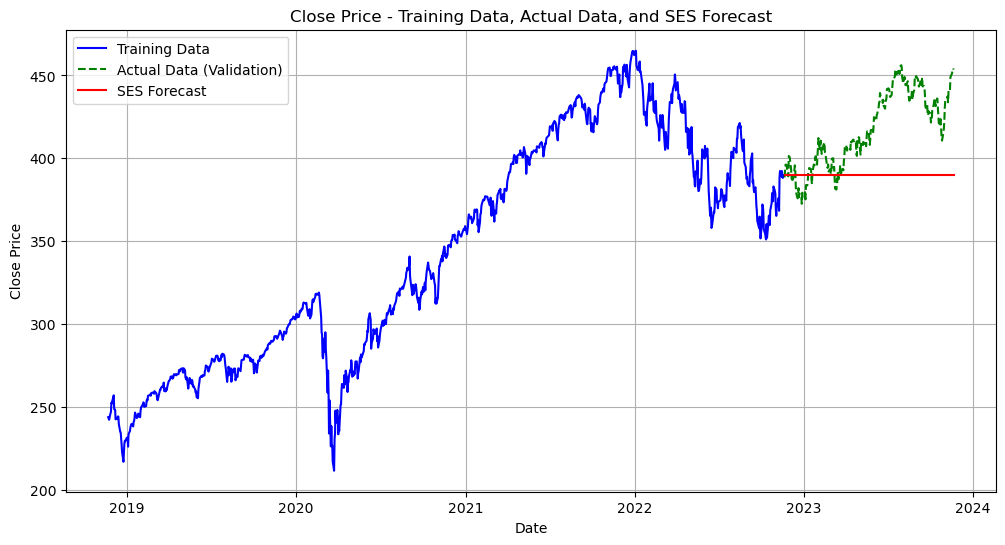

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

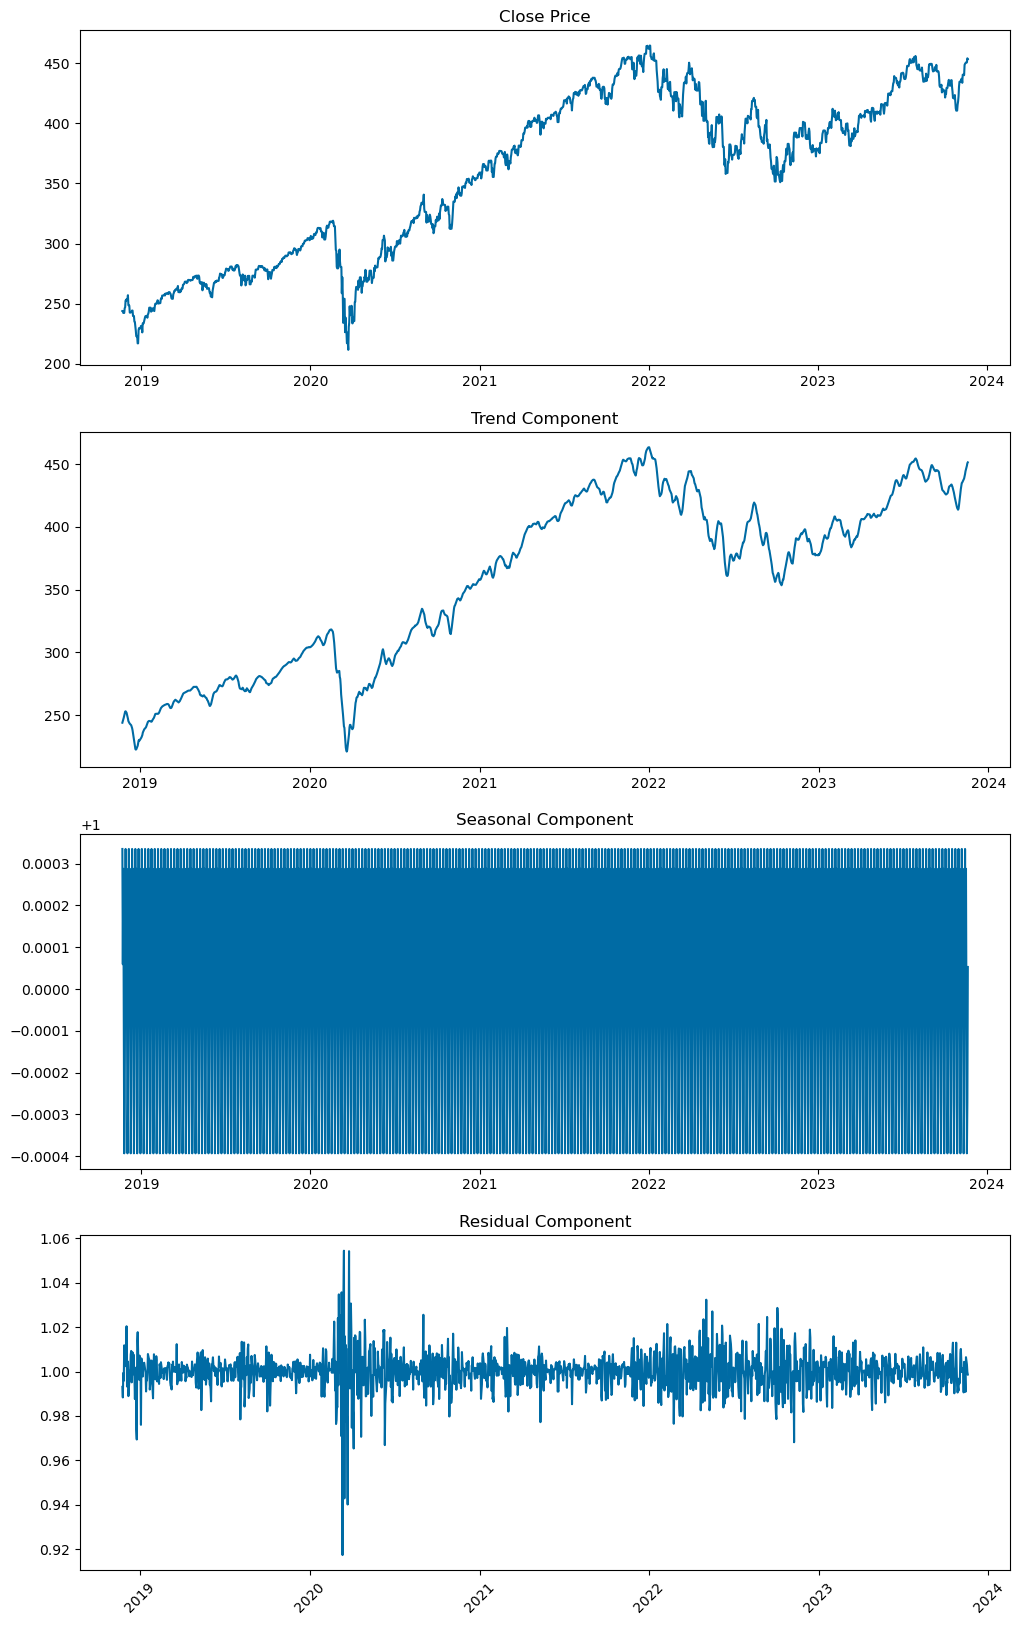

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

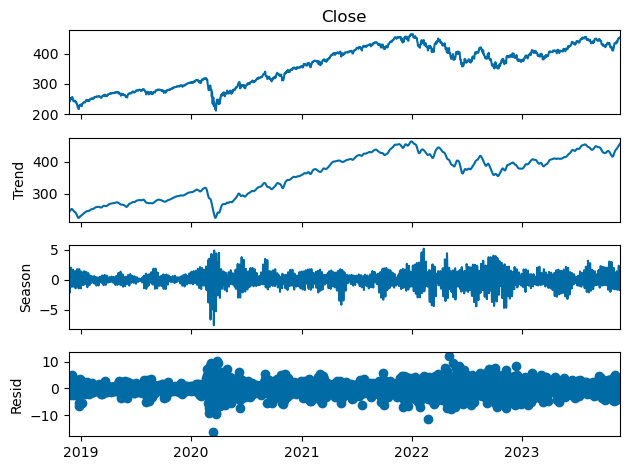

In [17]:
stl = STL(close).fit().plot()


### Autocorrelation - Raw Values

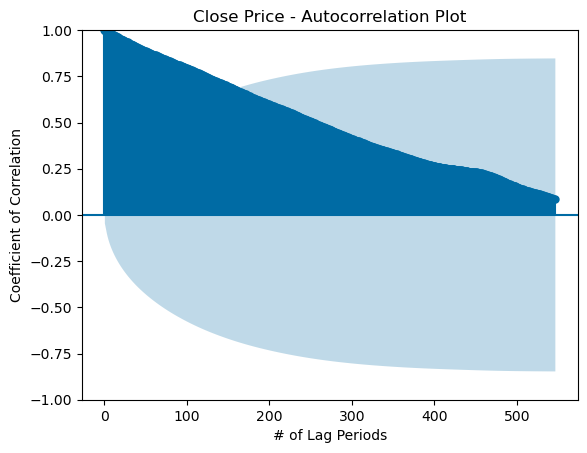

In [18]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

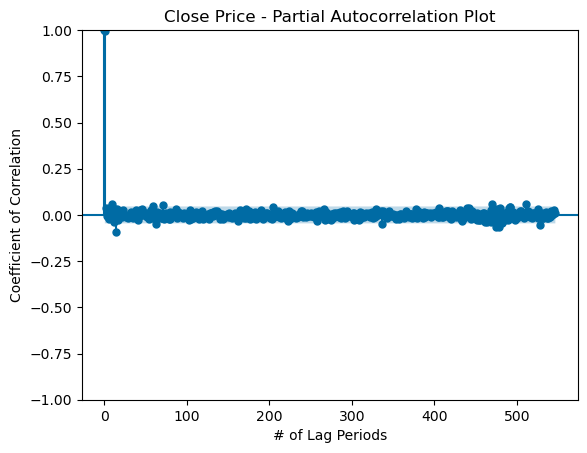

In [19]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

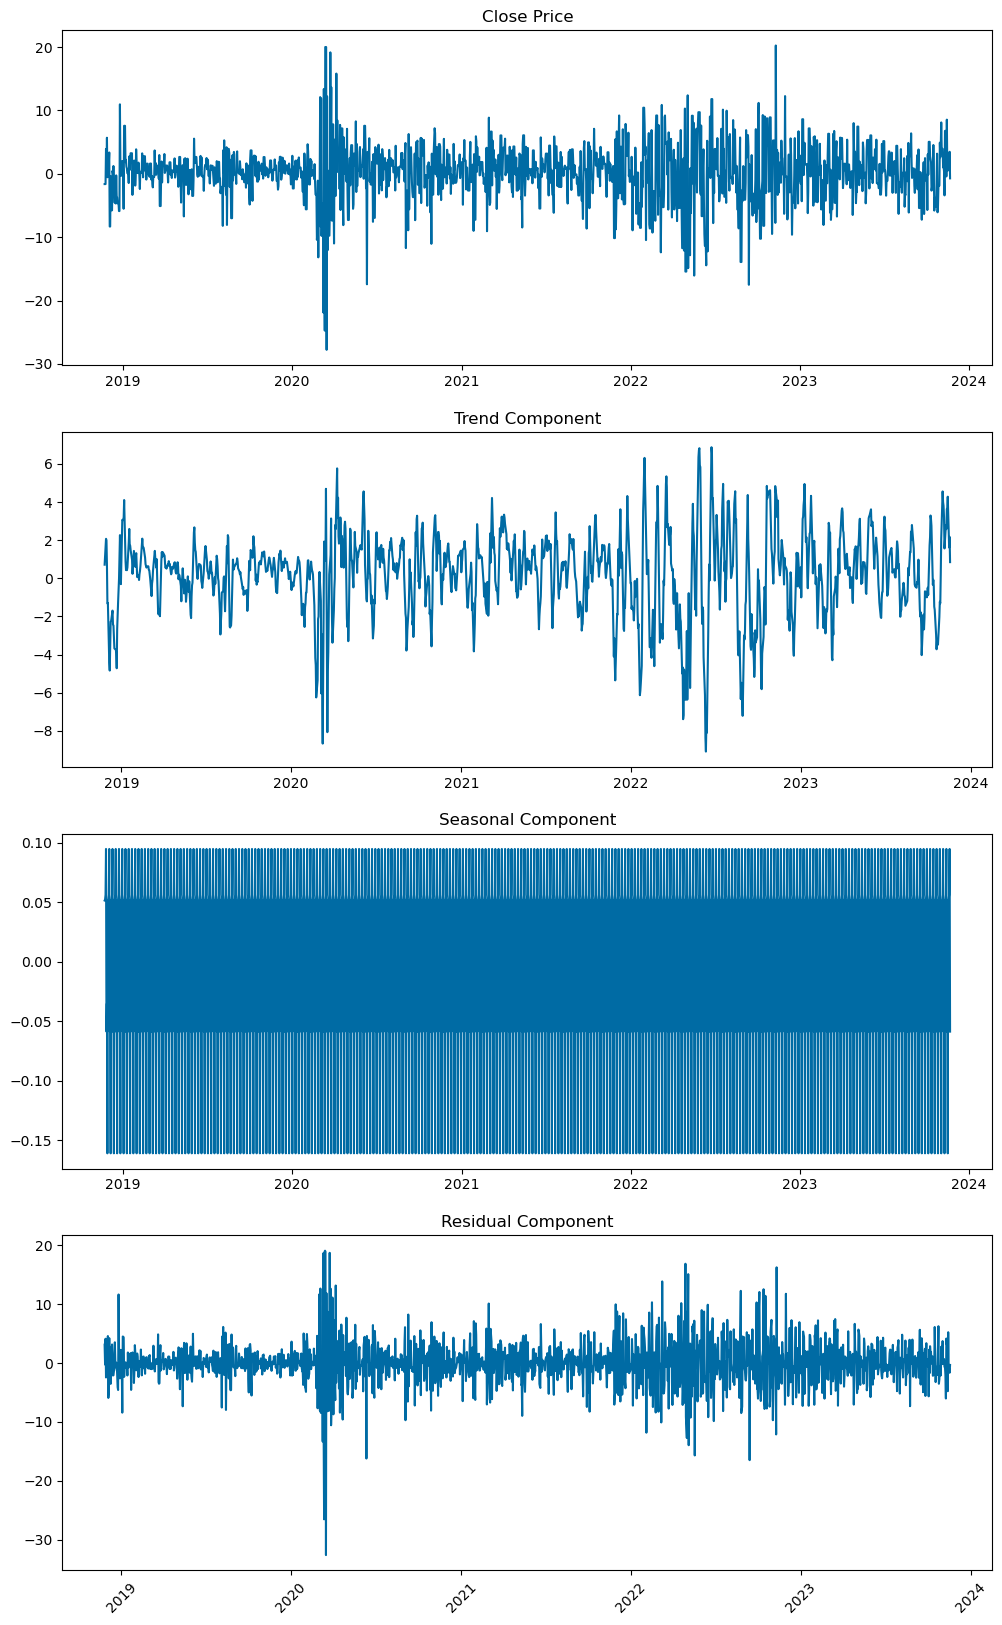

In [20]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

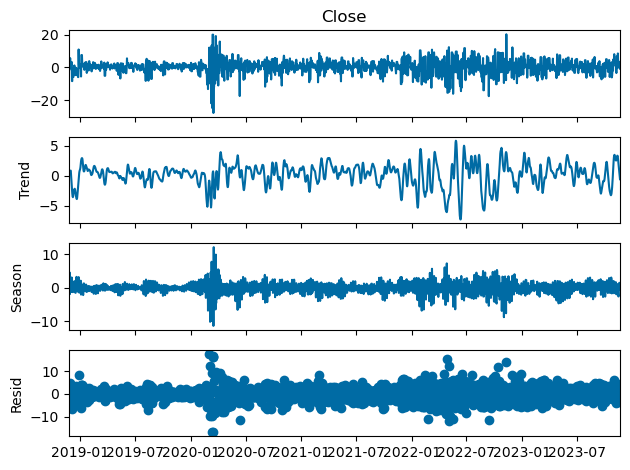

In [21]:
stl = STL(ts_lag_1).fit().plot()


# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

### ACF on lag_1 period

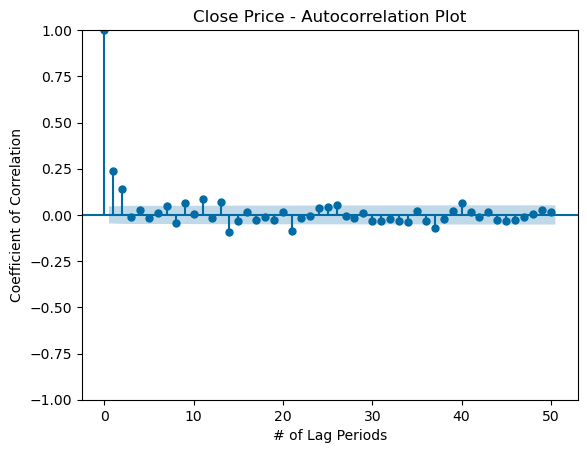

In [22]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we may want to do MA at 1, 2, 11, 13, 14, and 21.

### Plot PACF on lag_1 period

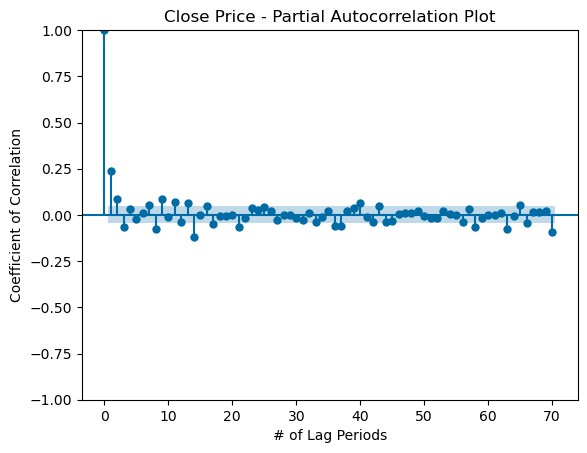

In [23]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

In [24]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC for AR(1): 10453.642991461467
BIC for AR(1): 10470.16935297337


AIC for AR(2): 10941.47157793913
BIC for AR(2): 10963.506726621667


AIC for AR(3): 10436.394952556191
BIC for AR(3): 10463.938888409362


AIC for AR(8): 10428.015261280474
BIC for AR(8): 10483.103132986816


AIC for AR(9): 10416.330428605615
BIC for AR(9): 10476.927087482592


AIC for AR(11): 10411.523439816061
BIC for AR(11): 10483.137673034307


AIC for AR(14): 10380.885946666298
BIC for AR(14): 10469.026541396446


AIC for AR(21): 10378.398310896391
BIC for AR(21): 10505.10041582098




### Select AR(14) due to lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

In [25]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [1, 2, 11, 13, 14, 21] #actually MA orders
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\L

AIC for MA(1): 10380.885946666298
BIC for MA(1): 10469.026541396446


AIC for MA(2): 10410.887279262395
BIC for MA(2): 10504.536661163178


AIC for MA(11): 10375.204812408614
BIC for MA(11): 10518.433278845105


AIC for MA(13): 10366.67191151401
BIC for MA(13): 10520.91795229177


AIC for MA(14): 10372.700581829438
BIC for MA(14): 10532.455409777833


AIC for MA(21): 10374.744628875467
BIC for MA(21): 10573.0609670183




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [26]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA

arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Time Series Evaluation Metrics
MSE = 174283.44380980724
MAE = 416.85354773995573
RMSE = 417.4726863039153
MAPE = 0.9995243525846734
r2 = -336.2443135331866



### Interpretation: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [27]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [28]:
#close_train.index

In [29]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [30]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3548.8738332490107
BIC = 3583.2699947036285
Time Series Evaluation Metrics
MSE = 1275.9047917676162
MAE = 29.308939945339176
RMSE = 35.71980951471629
MAPE = 0.0679043926340516
r2 = -1.4689185973565193



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

Results for Seasonal Period 3
AIC = 3862.164537095302
BIC = 3901.4744359005795
Time Series Evaluation Metrics
MSE = 1163.8517071020858
MAE = 27.766594474585897
RMSE = 34.11527087833373
MAPE = 0.06432177351746769
r2 = -1.2520921175071678

Results for Seasonal Period 8
AIC = 4436.938441092048
BIC = 4500.817026650624
Time Series Evaluation Metrics
MSE = 1892.0059641966138
MAE = 40.79538963996096
RMSE = 43.49719490032218
MAPE = 0.0980104272786771
r2 = -2.6610950452212525

Results for Seasonal Period 9
AIC = 4451.136035587375
BIC = 4519.928358496611
Time Series Evaluation Metrics
MSE = 2360.5627265349003
MAE = 45.51833909807282
RMSE = 48.585622631956674
MAPE = 0.10915413668626016
r2 = -3.567768107285315



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Results for Seasonal Period 11
AIC = 4540.3734175293985
BIC = 4618.9932151399535
Time Series Evaluation Metrics
MSE = 3429.358486175203
MAE = 55.18193247371078
RMSE = 58.560724775016254
MAPE = 0.1318390519264889
r2 = -5.635923775935187

Results for Seasonal Period 14
AIC = 4582.763183151693
BIC = 4676.124192814227
Time Series Evaluation Metrics
MSE = 5368.987642095088
MAE = 68.93622078320975
RMSE = 73.27337607954944
MAPE = 0.16419813267846753
r2 = -9.3891712955963

Results for Seasonal Period 21
AIC = 4412.209085695362
BIC = 4539.966256812514


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Time Series Evaluation Metrics
MSE = 1249.2229248822027
MAE = 29.057071123044416
RMSE = 35.34434784915691
MAPE = 0.06734174661483473
r2 = -1.4172882893659637

Results for Seasonal Period 58
AIC = 4791.886211851329
BIC = 5101.451664942889
Time Series Evaluation Metrics
MSE = 15430.413717484556
MAE = 116.54777548382178
RMSE = 124.21921637767869
MAPE = 0.27655971611955876
r2 = -28.858368459628274

Results for Seasonal Period 59
AIC = 4798.015106188171
BIC = 5112.494296630391
Time Series Evaluation Metrics
MSE = 8730.090710960507
MAE = 87.52976950639486
RMSE = 93.4349544386923
MAPE = 0.20788039569021668
r2 = -15.893018548068483



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

Results for Seasonal Period 60
AIC = 4793.92403307987
BIC = 5113.316960872749
Time Series Evaluation Metrics
MSE = 3997.697377719979
MAE = 59.082421850430286
RMSE = 63.22734675533981
MAPE = 0.14079214679890079
r2 = -6.735678607165145

Results for Seasonal Period 61
AIC = 4764.621788674623
BIC = 5088.928453818162
Time Series Evaluation Metrics
MSE = 3979.6429013459947
MAE = 59.33752803513416
RMSE = 63.08441092176414
MAPE = 0.14159127307067462
r2 = -6.700742589389469

Results for Seasonal Period 62
AIC = 4795.459903450965
BIC = 5124.680305945163
Time Series Evaluation Metrics
MSE = 12178.835427974735
MAE = 103.82298962305646
RMSE = 110.35776106814933
MAPE = 0.24663248984374772
r2 = -22.566455331369063

Results for Seasonal Period 63
AIC = 4775.626330636148
BIC = 5109.760470481006
Time Series Evaluation Metrics
MSE = 11113.334243826292
MAE = 98.53150044381627
RMSE = 105.4198000559017
MAPE = 0.23381965379236003
r2 = -20.504674776877177



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Results for Seasonal Period 64
AIC = 4724.849335971625
BIC = 5063.8972131671435
Time Series Evaluation Metrics
MSE = 5037.264671836236
MAE = 66.41714885555788
RMSE = 70.9736899973239
MAPE = 0.15801933068508528
r2 = -8.74727621398304

Results for Seasonal Period 65
AIC = 4721.402544776159
BIC = 5065.3641593223365
Time Series Evaluation Metrics
MSE = 2976.773763953369
MAE = 51.0106723338619
RMSE = 54.559818217744905
MAPE = 0.12179858126822024
r2 = -4.760157147592253

Results for Seasonal Period 70
AIC = 4790.106393889051
BIC = 5158.6366951885275
Time Series Evaluation Metrics
MSE = 10746.940159092357
MAE = 97.10467375659957
RMSE = 103.66744985332839
MAPE = 0.23057407033647623
r2 = -19.79568992503113



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [31]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3897.5117528733454
BIC = 3931.907914327963
Time Series Evaluation Metrics
MSE = 492.88098997817457
MAE = 17.81089280395297
RMSE = 22.200923178511623
MAPE = 0.04288429335577723
r2 = 0.0462587410187878

Results for Seasonal mul
AIC = 3895.0710888559724
BIC = 3929.4672503105903
Time Series Evaluation Metrics
MSE = 641.1177456178674
MAE = 20.520066888445033
RMSE = 25.320303031714833
MAPE = 0.04926156648750882
r2 = -0.24058435665749167

Results for Seasonal additive
AIC = 3897.5117528733454
BIC = 3931.907914327963
Time Series Evaluation Metrics
MSE = 492.88098997817457
MAE = 17.81089280395297
RMSE = 22.200923178511623
MAPE = 0.04288429335577723
r2 = 0.0462587410187878

Results for Seasonal multiplicative
AIC = 3895.0710888559724
BIC = 3929.4672503105903
Time Series Evaluation Metrics
MSE = 641.1177456178674
MAE = 20.520066888445033
RMSE = 25.320303031714833
MAPE = 0.04926156648750882
r2 = -0.24058435665749167

Results for Seasonal None
AIC = 4656.873307218709


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

### Validation statistics suggest additive seasonality is optimal

### Searching for ideal trend parameter

In [32]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

Results for Trend add
AIC = 3861.936094619556
BIC = 3901.2459934248336
Time Series Evaluation Metrics
MSE = 1180.0440425648949
MAE = 27.985153664260302
RMSE = 34.351769132970354
MAPE = 0.0648280258484952
r2 = -1.2834248301176285

Results for Trend mul
AIC = 3893.444489323105
BIC = 3932.7543881283823
Time Series Evaluation Metrics
MSE = 189.73263666110387
MAE = 11.651405196460455
RMSE = 13.77434705026354
MAPE = 0.028313683244596637
r2 = 0.6328609797529439

Results for Trend additive
AIC = 3861.936094619556
BIC = 3901.2459934248336
Time Series Evaluation Metrics
MSE = 1180.0440425648949
MAE = 27.985153664260302
RMSE = 34.351769132970354
MAPE = 0.0648280258484952
r2 = -1.2834248301176285

Results for Trend multiplicative
AIC = 3893.444489323105
BIC = 3932.7543881283823
Time Series Evaluation Metrics
MSE = 189.73263666110387
MAE = 11.651405196460455
RMSE = 13.77434705026354
MAPE = 0.028313683244596637
r2 = 0.6328609797529439



ValueError: Can only dampen the trend component

### Validation statistics suggest multiplicative trend is optimal

### Searching for ideal aes_param_damped_trend parameter

In [33]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3907.142663778436
BIC = 3946.4525625837136
Time Series Evaluation Metrics
MSE = 200.17295159718617
MAE = 11.550974364913401
RMSE = 14.148249064714198
MAPE = 0.027500264051772663
r2 = 0.6126586199262027

Results for Damped Trend False
AIC = 3897.5120125220656
BIC = 3931.9081739766834
Time Series Evaluation Metrics
MSE = 492.8774371952388
MAE = 17.810821409907266
RMSE = 22.20084316406111
MAPE = 0.04288412373897075
r2 = 0.046265615773016466



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [34]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3911.9235785679057
BIC = 3946.3197400225235
Time Series Evaluation Metrics
MSE = 261.22143206339456
MAE = 13.028769189439013
RMSE = 16.16234611878469
MAPE = 0.031571359516141796
r2 = 0.49452776115376396

Results for Initialization Method estimated
AIC = 3898.737030738884
BIC = 3933.133192193502
Time Series Evaluation Metrics
MSE = 279.18348881118385
MAE = 13.443907165815329
RMSE = 16.708784779605722
MAPE = 0.03257340471659043
r2 = 0.4597705784568068

Results for Initialization Method heuristic
AIC = 3899.6784034241196
BIC = 3934.0745648787374
Time Series Evaluation Metrics
MSE = 282.1255273873842
MAE = 13.510993474321516
RMSE = 16.79659273148528
MAPE = 0.03273498162390221
r2 = 0.4540776350633908

Results for Initialization Method legacy-heuristic
AIC = 3911.9235785679057
BIC = 3946.3197400225235
Time Series Evaluation Metrics
MSE = 261.22143206339456
MAE = 13.028769189439013
RMSE = 16.16234611878469
MAPE = 0.031571359516141796
r2 = 0.4945277

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [35]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC = 3888.8234527498184
BIC = 3928.133351555096
Time Series Evaluation Metrics
MSE = 255.17315280786826
MAE = 13.221787210442185
RMSE = 15.974140127339195
MAPE = 0.03141641484824828
r2 = 0.5062313845215288

None


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


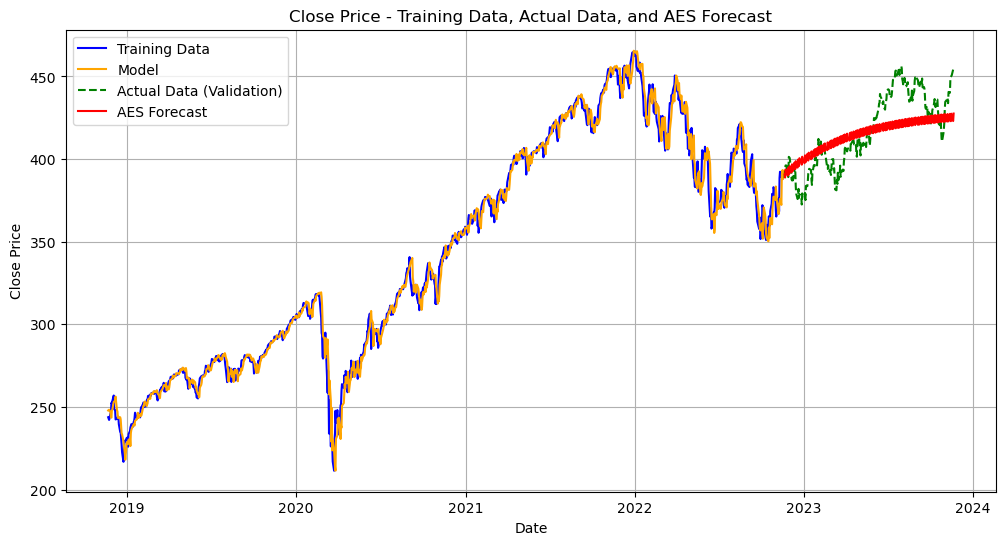

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [37]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3561.196562607739
BIC = 3595.592724062357
Time Series Evaluation Metrics
MSE = 584.7040420317771
MAE = 19.280814032129655
RMSE = 24.180654292880025
MAPE = 0.04474500648149622
r2 = -0.13142194671270335

None


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


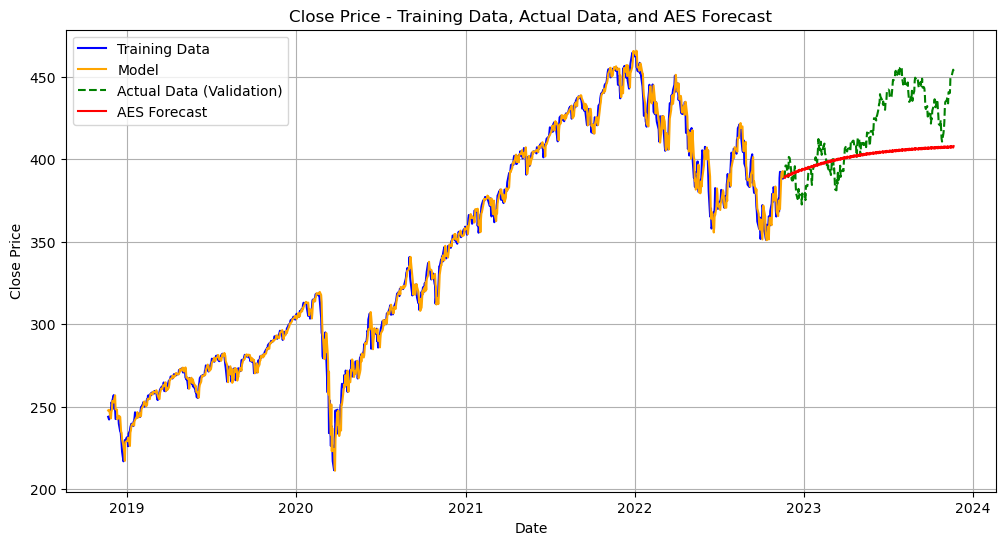

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [39]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,0)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                ARIMA(14, 1, 0)   Log Likelihood               -2939.214
Date:                Tue, 21 Nov 2023   AIC                           5908.428
Time:                        10:05:05   BIC                           5987.701
Sample:                    11-21-2018   HQIC                          5938.002
                         - 11-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1334      0.031     -4.252      0.000      -0.195      -0.072
ar.L2         -0.1100      0.031     -3.522      0.000      -0.171      -0.049
ar.L3          0.2008      0.033      6.083      0.0

In [40]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

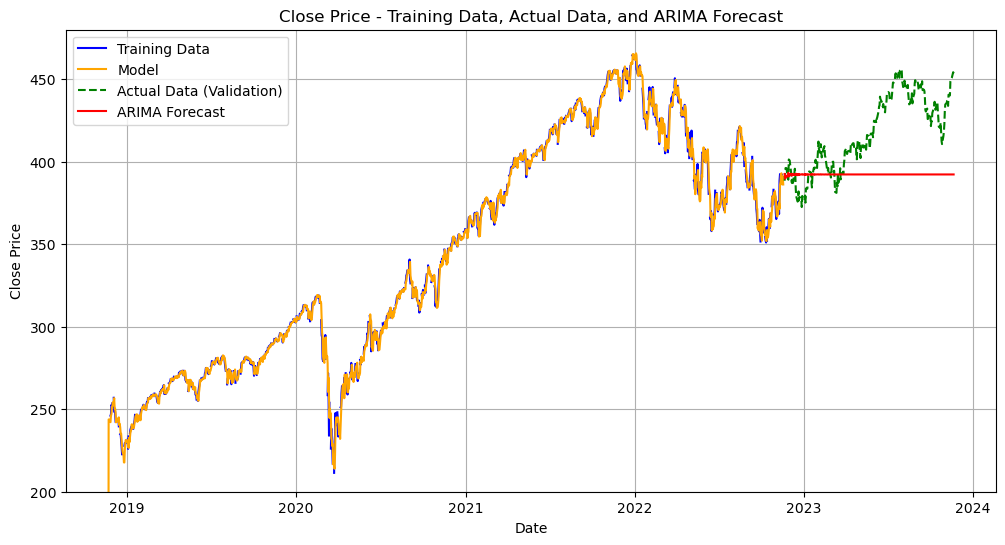

In [41]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Binary Field on positive/ negative of Open - Close

#### Data Stationary

In [42]:
hist = aapl.history(period = '1y')
hist_lag_1 = hist.diff()
# hist_lag_1 = hist.diff(periods=14)
# hist_lag_1 = hist.shift(2)
hist_lag_1 = hist_lag_1.dropna()

#### Add new columns

In [43]:
hist_lag_1['open_close'] = hist_lag_1['Close'] - hist_lag_1['Open']
hist_lag_1['positive'] = np.where(hist_lag_1['open_close'] >= 0, 1, 0)
hist_lag_1['high_low'] = hist_lag_1['High'] - hist_lag_1['Low']

# positive = hist_lag_1['positive']
# plt.figure(figsize=(14, 6))
# plt.plot(positive)
# plt.xlabel('Date')
# plt.ylabel('Positive')
# plt.title('SPY 150 days up/down')
# plt.show()
# hist_lag_1.describe()

#### Data Partition

In [44]:
X = hist_lag_1.drop(['positive'], axis =1)
# X = hist_lag_1[['open_close','Volume','high_low']]
y = hist_lag_1['positive']

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


#### Logistics Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

logreg_pred = logreg_model.predict(X_valid)

logreg_coef = logreg_model.coef_
logreg_intercept = logreg_model.intercept_

logreg_accuracy = accuracy_score(y_valid, logreg_pred)
logreg_cm = confusion_matrix(y_valid, logreg_pred)
# logreg_classrpt = classification_report(y_valid, logreg_pred)
tn, fp, fn, tp = logreg_cmg.ravel()
logreg_sensi = tp / (tp + fn)
logreg_speci = tn / (tn + fp)

print(f'Accuracy: {logreg_accuracy:.2%}')
print(f'Sensitivity: {logreg_sensi:.2f}')
print(f'Specificity: {logreg_speci:.2f}')

sns.set(font_scale=0.9)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False,
            xticklabels=['Predicted [0]', 'Predicted [1]'],
            yticklabels=['Actual [0]', 'Actual [1]'])
plt.title('Confusion Matrix')
plt.show()

NameError: name 'conf_matrix' is not defined

In [ ]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [ ]:
startdate = datetime(2020,3,16)
today = date.today()
enddate = today

In [ ]:
stocks

In [ ]:
test = aapl.history(period='1mo')
test?

In [ ]:
aapl.get_shares_full(start="2022-01-01", end=None)

In [ ]:
opt_df = aapl.option_chain('2023-12-29')
call = opt_df.calls
put = opt_df.puts
put

In [ ]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [ ]:
put.describe()

In [ ]:
#df_temp

In [ ]:
aapl.options

## Amazon  - Gabi in progress

In [ ]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
amzn.history_metadata

In [ ]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

In [ ]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Partition train and validation datasets: 

train = amzn_df.loc['2018-11-09':'2022-12-01']
train = train['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.loc['2022-12-02':'2023-11-08']

In [ ]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [ ]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_train, period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

In [ ]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt's Winter Smoothing

In [ ]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

In [ ]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection

In [ ]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(amzn_train, label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

In [ ]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,9), datetime(2022,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2023,1,1))

In [ ]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_train[(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

In [ ]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_train)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')

In [ ]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

### Transforming Time Series to Stationary

In [ ]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [ ]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

### Selecting a Model

In [ ]:
# ACF suggest MA Lag 1 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


In [ ]:
# Auto ARIMA Model: 
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

auto_arima_model = auto_arima(diff_ts, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

val_close = valid['Close'].asfreq('D')
arima_pred = auto_arima_model.predict(n_periods=len(val_close))

In [ ]:
# ARIMA Model and Forecast at ARIMA(5,1,0): 

arima_m = sm.tsa.ARIMA(diff_ts, order=(5,1,0)).fit() 
print(arima_m.summary())

arima_pred = arima_m.forecast(steps=len(val_close))

In [ ]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')

plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(diff_ts, label='Training Data', color='blue')
#plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
#plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
#plt.plot(val_close.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    